# Examen Práctico 

#### 3670 COM:01-3900 | Ciencia de datos | 2024 C2

Alumnos:
Ruiz Diaz Manuel Santiago
Ruiz Alejandro
Ojeda Ernesto
Giardelli Alan Nahuel
Ayala Fernando Ariel

## Enunciado

Se tiene un dataset con datos del historial de solicitantes a quienes se le otorgaron créditos y su situación final como deudores o pagadores. La entidad tiene que determinar a quienes entregar o no un crédito en función de su propensión a caer en "default". Desarrolle un proceso que clasifique deudores y pagadores. Observe que la clase de interés es "default", y debido a nuevas políticas de encaje bancario se ha expresado el objetivo de evitar tanto como sea posible entregar créditos a deudores (a costa naturalmente de perder algún posible crédito a pagadores). Maximice la métrica correspondiente sin modificar threshold.

 Las columnas tienen nombres descriptivos, pero para mas información:

Importe: Cuando dinero esta pidiendo prestado</BR>
añosPago: Tiempo para pagar el crédito</BR>
IngresoAnuales: Ingresos anuales del solicitante</BR>
RelacionIngresoDeuda: Ratio entre sus ingresos y la deuda</BR>
RelacionCuotaDeuda: Ratio entre sus ingresos y la cuota</BR>
PendienteEnTarjeta: Pendiente de pago en tarjetas de crédito</BR>
UsoCreditoTarjeta: Volumen de dinero que maneja con sus instrumentos de crédito</BR>
Objetivo: ¿Para que quiere el préstamos?</BR>
esPropietario: ¿Es propietario del su casa?</BR>
FueVeraz: ¿Alguna vez estuvo en el veraz?</BR>
TuvoEmbargo: ¿Tuvo algun embargo o situación judicial?</BR>
Cuentas: Cantidad de cuentas que maneja</BR>
PuntuacionGeneral: Puntuación crediticia otorgada por un organismo regular</BR>
Default: Si pagó o no el crédito</BR>
AntiguedadLaboral: Antiguedad laboral</BR>

## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general. 

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR> 



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente, recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos. Ej: "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si EVALUACION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando al fuga de datos).Puede dejar funcionando implementaciones alternativas que no prosperaron en notebooks separados. En cuanto comience con el desarrollo informe a los docentes el nombre del repositorio.


## Evaluacion final - Docente + Alumno

In [127]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt


Lectura de los datos

In [128]:
df = pd.read_csv(STUDENTDATAFILE)

Declaramos transformaciones de pipeline que vimos en clase y otras que desarrollamos en TPs

In [134]:
# Imputer con mean por defecto
class ColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean"), columns=None):
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self    
    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()
    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.imputer.transform(X[self.columns])
        return Xc
    
# Imputer con mean por defecto sobre todas las columnas
class AllColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean")):
        self.imputer = imputer

    def fit(self, X, y=None):
        self.numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
        self.imputer.fit(X[self.numeric_columns])
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X[self.numeric_columns] = self.imputer.transform(X[self.numeric_columns])
        return X

# Se dropean las columnas que tengan un 70% de valores nulos
class ColumnDropNulls(BaseEstimator, TransformerMixin):
    def __init__(self, treshold=70):
        self.treshold = treshold
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        overseventy = (Xc.isnull().sum()/len(Xc)*100).where(lambda x: x > self.treshold).dropna()
        names = overseventy.index.tolist()
        for name in names:
            Xc.drop(columns=[name], inplace=True)
        return Xc

# Se qutian las columnas que tienen mas del 70% de valores iguales
class ColumnDropUnique(BaseEstimator, TransformerMixin):
    def __init__(self, treshold=70):
        self.treshold = treshold
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        unique = (Xc.nunique()/len(Xc)*100).where(lambda x: x > self.treshold).dropna()
        names = unique.index.tolist()
        outputs = [Xc]
        print('DEBUG: ', names)
        for name in names:
            aux = outputs[-1]
            Xc.drop(columns=[name], inplace=True)

        return Xc

# Se quitan las columnas que se pasen por parametro
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        Xc.drop(columns=self.columns, inplace=True)
        return Xc

# OneHotEncoder para columnas que se pasen por parametro
class ColumnOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=OneHotEncoder(drop='first', sparse_output=False), columns=None):
        self.encoder = encoder
        self.columns = columns

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self    
    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out()
    
    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.encoder.get_feature_names_out()] = self.encoder.transform(Xc[self.columns])
        Xc.drop(columns=self.columns, inplace=True)
        return Xc
    
# Redondear para columnas que se pasen por parametro
class ColumnRound(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, decimals=0):
        self.columns = columns
        self.decimals = decimals

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xc = X.copy()
        Xc[self.columns] = Xc[self.columns].round(self.decimals)
        return Xc

# Inspección inicial de los datos

In [135]:
df.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7
3,33425,5,75000,20.85,14.08580,25807,60.7,Deuda,Hipoteca,0,1,14,4.0,paid off,11
4,15000,5,55000,7.66,9.43025,8452,49.4,Deuda,Alquiler,1,1,10,1.4,default,4


Calculamos la cantidad de valores nulos por columna

In [136]:
# Vemos que no hay columnas con valores nulos
(df.isnull().sum()/len(df)*100)

Importe                 0.0
añosPago                0.0
IngresoAnuales          0.0
RelacionIngresoDeuda    0.0
RelacionCuotaDeuda      0.0
PendienteEnTarjeta      0.0
UsoCreditoTarjeta       0.0
Objetivo                0.0
esPropietario           0.0
FueVeraz                0.0
TuvoEmbargo             0.0
Cuentas                 0.0
PuntuacionGeneral       0.0
Default                 0.0
AntiguedadLaboral       0.0
dtype: float64

Calculamos la cantidad de valores unicos por columna, para detectar identificadores unicos que no aportan valor predictivo

In [137]:
# Relacion CuotaDeuda parece no aportar mucho
(df.nunique()/len(df)*100)

Importe                  3.072987
añosPago                 0.005881
IngresoAnuales          12.465447
RelacionIngresoDeuda    10.127625
RelacionCuotaDeuda      89.925307
PendienteEnTarjeta      60.971593
UsoCreditoTarjeta        3.114156
Objetivo                 0.035288
esPropietario            0.011763
FueVeraz                 0.005881
TuvoEmbargo              0.005881
Cuentas                  0.138211
PuntuacionGeneral        0.102923
Default                  0.005881
AntiguedadLaboral        0.035288
dtype: float64

Si bien RelacionCuotaDeuda tiene muchos valores únicos, eso es porque es un tipo flotante con muchos decimales. Los decimales no aportan mucha información del mismo modo que si se estimara el peso de toda la población con 100 decimales de precisión, es muy probable que cada valor sea único.

Analizamos la matriz de correlacion de las columnas con valores enteros y floteantes

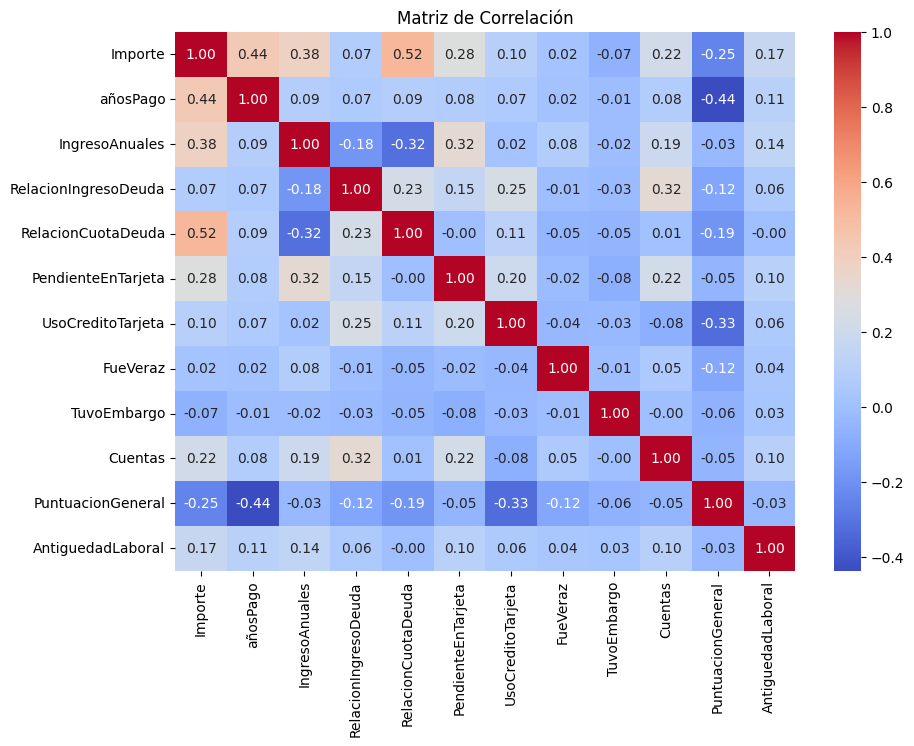

In [138]:
mat = df.select_dtypes(include=['int', 'float']).corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

# RESOLUCIÓN

Obtenemos los quartiles de las columnas numéricas

In [139]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Importe,34006.0,NaN,NaN,NaN,13172.604099,8101.327372,500.0,7000.0,11500.0,18000.0,35000.0
añosPago,34006.0,NaN,NaN,NaN,3.503441,0.868015,3.0,3.0,3.0,5.0,5.0
IngresoAnuales,34006.0,NaN,NaN,NaN,68136.860583,45495.765008,3500.0,42000.0,60000.0,82000.0,1200000.0
RelacionIngresoDeuda,34006.0,NaN,NaN,NaN,16.110743,7.59336,0.0,10.46,16.01,21.56,38.6
RelacionCuotaDeuda,34006.0,NaN,NaN,NaN,8.026282,4.267497,0.048892,4.659375,7.49215,10.935325,43.5456
PendienteEnTarjeta,34006.0,NaN,NaN,NaN,14973.249074,21086.541027,0.0,5676.5,10807.5,18668.75,1743266.0
UsoCreditoTarjeta,34006.0,NaN,NaN,NaN,56.087961,25.437684,0.0,38.0,58.5,76.5,119.0
Objetivo,34006,12,Deuda,19141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
esPropietario,34006,4,Hipoteca,15705,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FueVeraz,34006.0,NaN,NaN,NaN,0.143239,0.350322,0.0,0.0,0.0,0.0,1.0


Vemos que la diferencia entre 75% y Max para las columnas PuntuacionGeneral, IngresoAnuales, RelacionIngresoDeuda y PendienteEnTarjeta son muy altas, posiblemente tengan outliers. 

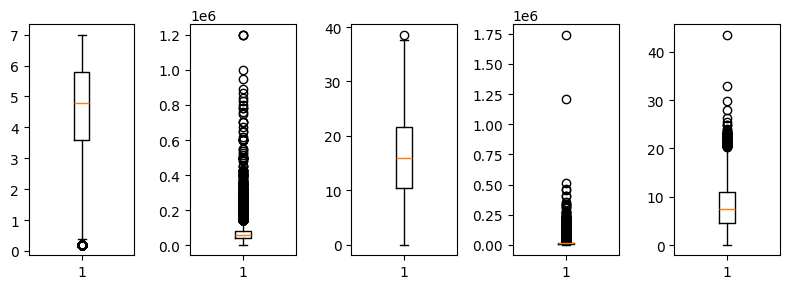

In [140]:
bxColumns = ["PuntuacionGeneral", "IngresoAnuales", "RelacionIngresoDeuda", "PendienteEnTarjeta", "RelacionCuotaDeuda"]
fig, axs = plt.subplots(1, len(bxColumns), figsize=(8, 3))
for c,i in zip(bxColumns, range(len(bxColumns))):
    axs[i].boxplot(df[c])
   
plt.tight_layout()
plt.show()

1. PuntuacionGeneral tiene varios casos con ~0 que no parecen ser representativos del dataset.  
2. IngresoAnuales tiene mucho desvío  
3. RelacionIngresoDeuda y PendienteEnTarjeta tienen outliers muy altos.   
4. RelacionCuotaDeuda tiene muchos valores distintos

Vamos por partes

### PuntacionGeneral tiene outliers en 0 no representativos?

<Axes: >

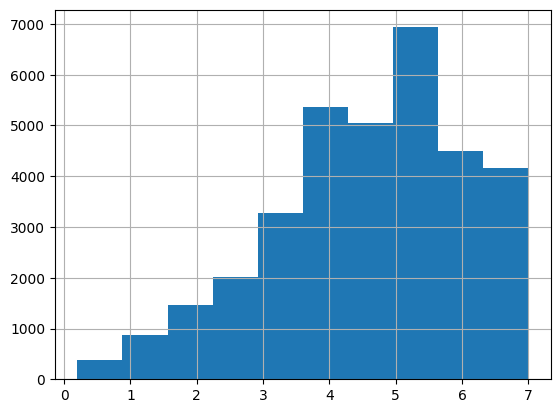

In [141]:
df['PuntuacionGeneral'].hist()

In [142]:
# Veamos el porcentaje de valores <N para 0 hasta 7
for i in range(8):
    print(f"Porcentaje de valores <{i}: {len(df[df['PuntuacionGeneral'] < i])/len(df)*100}")

Porcentaje de valores <0: 0.0
Porcentaje de valores <1: 1.1321531494442156
Porcentaje de valores <2: 5.35493736399459
Porcentaje de valores <3: 13.906369464212197
Porcentaje de valores <4: 30.471093336470034
Porcentaje de valores <5: 54.149267776274776
Porcentaje de valores <6: 80.8122096100688
Porcentaje de valores <7: 96.14773863435863


Los valores <1 no son representativos puesto que conforman menos del 2.5% marginal de la distribución. Podemos sacarlos como outliers

### IngresosAnuales tiene mucho desvío?

In [143]:
df.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7
3,33425,5,75000,20.85,14.08580,25807,60.7,Deuda,Hipoteca,0,1,14,4.0,paid off,11
4,15000,5,55000,7.66,9.43025,8452,49.4,Deuda,Alquiler,1,1,10,1.4,default,4


<Axes: >

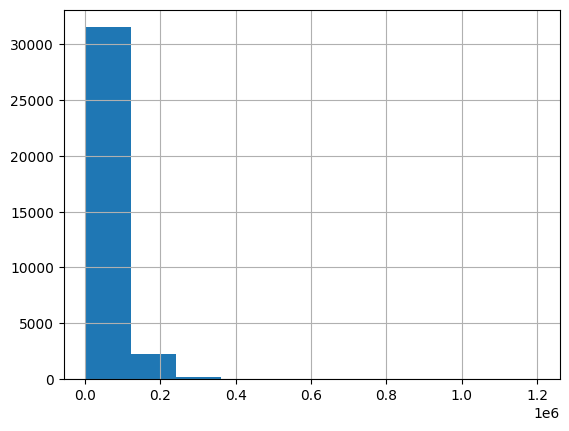

In [144]:
df['IngresoAnuales'].hist()

Notamos que la escala esta en 1x10^6, esto es porque hay 1 outlier con un ingreso anual privilegiado de 1.2 millones. El bin de la izqauierda está concentrando todos los ingresos entre 0 y 200.000, generando el sesgo a izquierda del gráfico.  
Podemos graficar el histograma sin los extremos 5%

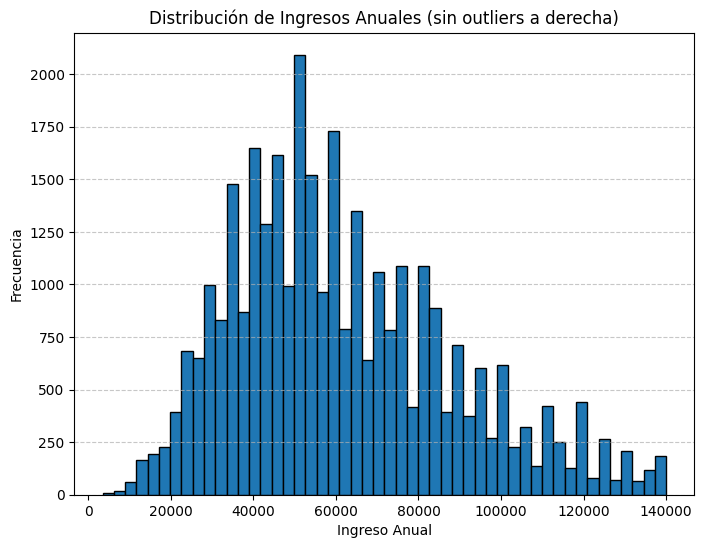

In [145]:
plt.figure(figsize=(8, 6))
plt.hist(df['IngresoAnuales'], bins=50, range=(df['IngresoAnuales'].min(), df['IngresoAnuales'].quantile(0.95)), edgecolor='black')
plt.title('Distribución de Ingresos Anuales (sin outliers a derecha)')
plt.xlabel('Ingreso Anual')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Debemos eliminar los outliers de la columna IngresoAnuales

### RelacionIngresoDeuda y PendienteEnTarjeta tienen outliers muy altos?

<Axes: >

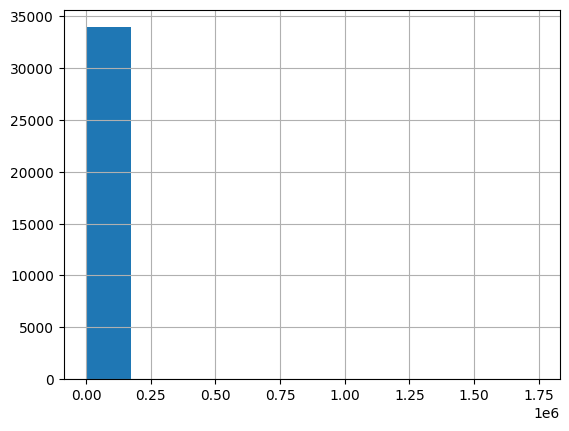

In [146]:
df['PendienteEnTarjeta'].hist()

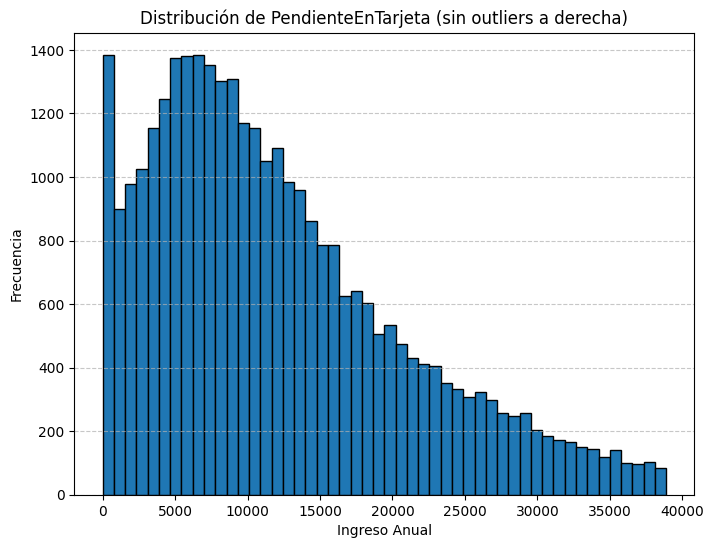

In [147]:
plt.figure(figsize=(8, 6))
plt.hist(df['PendienteEnTarjeta'], bins=50, range=(df['PendienteEnTarjeta'].min(), df['PendienteEnTarjeta'].quantile(0.95)), edgecolor='black')
plt.title('Distribución de PendienteEnTarjeta (sin outliers a derecha)')
plt.xlabel('Ingreso Anual')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Mismo analisis que antes, PendienteEnTarjeta tiene outliers que quitar

<Axes: >

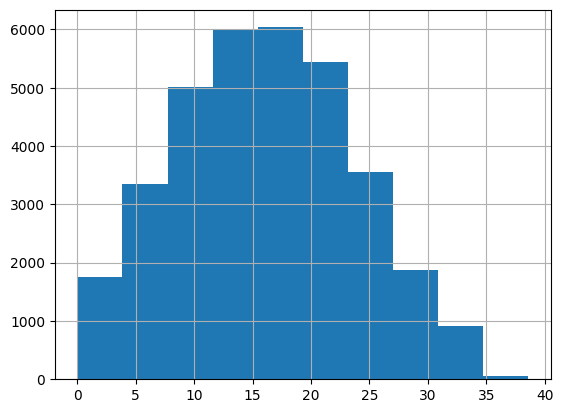

In [148]:
df['RelacionIngresoDeuda'].hist()

No parece estar sesgada la distribución de RelacionIngresoDeuda, sólo tiene un punto en 39

In [149]:
from sklearn.base import BaseEstimator, TransformerMixin

# Creamos una clase para remover outliers de una columna y reemplazarlos por NaN, para luego imputarlos
class ColumnOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, column, method='iqr', factor=1.5, replace_with_nan=False):
        self.column = column
        self.method = method
        self.factor = factor
        self.replace_with_nan = replace_with_nan

    def fit(self, X, y=None):
        if self.method == 'iqr':
            q1 = X[self.column].quantile(0.25)
            q3 = X[self.column].quantile(0.75)
            self.lower_bound = q1 - self.factor * (q3 - q1)
            self.upper_bound = q3 + self.factor * (q3 - q1)
        elif self.method == 'zscore':
            self.mean = X[self.column].mean()
            self.std = X[self.column].std()
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if self.method == 'iqr':
            mask = (X[self.column] >= self.lower_bound) & (X[self.column] <= self.upper_bound)
        elif self.method == 'zscore':
            z_scores = (X[self.column] - self.mean) / self.std
            mask = (z_scores >= -self.factor) & (z_scores <= self.factor)
        
        if self.replace_with_nan:
            X.loc[~mask, self.column] = float('nan')
        else:
            X = X[mask]
        
        return X

class RemoveAllOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, method='iqr', factor=1.5, replace_with_nan=False):
        self.method = method
        self.factor = factor
        self.replace_with_nan = replace_with_nan
        self.bounds = {}

    def fit(self, X, y=None):
        numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
        for column in numeric_columns:
            if self.method == 'iqr':
                q1 = X[column].quantile(0.25)
                q3 = X[column].quantile(0.75)
                lower_bound = q1 - self.factor * (q3 - q1)
                upper_bound = q3 + self.factor * (q3 - q1)
                self.bounds[column] = (lower_bound, upper_bound)
            elif self.method == 'zscore':
                mean = X[column].mean()
                std = X[column].std()
                lower_bound = mean - self.factor * std
                upper_bound = mean + self.factor * std
                self.bounds[column] = (lower_bound, upper_bound)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for column, (lower_bound, upper_bound) in self.bounds.items():
            if self.method == 'iqr':
                mask = (X[column] >= lower_bound) & (X[column] <= upper_bound)
            elif self.method == 'zscore':
                mask = (X[column] >= lower_bound) & (X[column] <= upper_bound)
            
            if self.replace_with_nan:
                X.loc[~mask, column] = float('nan')
            else:
                X = X[mask]
        
        return X


In [150]:
X = df.drop(columns='Default')
y = (df['Default'] == 'default').astype(int)  # Convertir a binario para MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Dado que tenemos que priorizar evitar los falsos negativos, la métrica a maximizar por el gridsearch es **Recall**

In [151]:
pl = Pipeline(steps=[
     ("round", ColumnRound(columns=['RelacionCuotaDeuda'])),
     ("one_hot", ColumnOneHot(columns=['Objetivo', 'esPropietario'])),
     ("outlier", ColumnOutlierRemover(column='IngresoAnuales', method='iqr', factor=1.5, replace_with_nan=True)),
     ("outlier2", ColumnOutlierRemover(column='PendienteEnTarjeta', method='iqr', factor=1.5, replace_with_nan=True)),
     ("outlier3", ColumnOutlierRemover(column='PuntuacionGeneral', method='iqr', factor=1.5, replace_with_nan=True)),
     ("outlier4", ColumnOutlierRemover(column='RelacionCuotaDeuda', method='iqr', factor=1.5, replace_with_nan=True)),
     ("imputer", ColumnImputer(columns=['IngresoAnuales', 'PendienteEnTarjeta', 'PuntuacionGeneral', 'RelacionCuotaDeuda'])),
     ('scaler', StandardScaler()), 
     ('classifier', RandomForestClassifier())
])


# Definir parámetros para cada clasificador
param_grid = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__max_depth': [10, 11, 12, 13, 14, 15]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [10, 12, 15]
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [10, 11, 12, 13, 14, 15],
        'classifier__criterion': ['gini', 'entropy']
    },
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier': [MLPClassifier(max_iter=500)],
        'classifier__hidden_layer_sizes': [(32, 16, 8), (16, 8, 8, 4)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam', 'sgd'],
        'classifier__learning_rate': ['constant', 'adaptive']
    },
    {
        'classifier': [GaussianNB()]
    }
]

# Realizar la búsqueda con GridSearchCV
grid_search = GridSearchCV(pl, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Mejor modelo: {type(best_model.named_steps['classifier']).__name__}")
print("Mejores parámetros:", best_params)
                                                                    
# Evaluar en el conjunto de prueba
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 62 candidates, totalling 310 fits
Mejor modelo: SVC
Mejores parámetros: {'classifier': SVC(), 'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      5069
           1       0.63      0.67      0.65      5133

    accuracy                           0.64     10202
   macro avg       0.64      0.64      0.64     10202
weighted avg       0.64      0.64      0.64     10202



Luego de quitar los outliers, vemos una mejora muy pequeña en Recall y F1, pero no en accuracy.  
Este experimento lo hicimos imputando los outliers de todas las columnas como también sólo de las columnas analizadas, con SimpleImputer usando mean y con KNNImputer, sin diferencias significativas.

In [152]:
print(best_params)

{'classifier': SVC(), 'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


### Análisis del target

In [153]:
print(y_train.value_counts(normalize=True)) #Está desbalanceado el target? Parece que no


Default
0    0.501344
1    0.498656
Name: proportion, dtype: float64


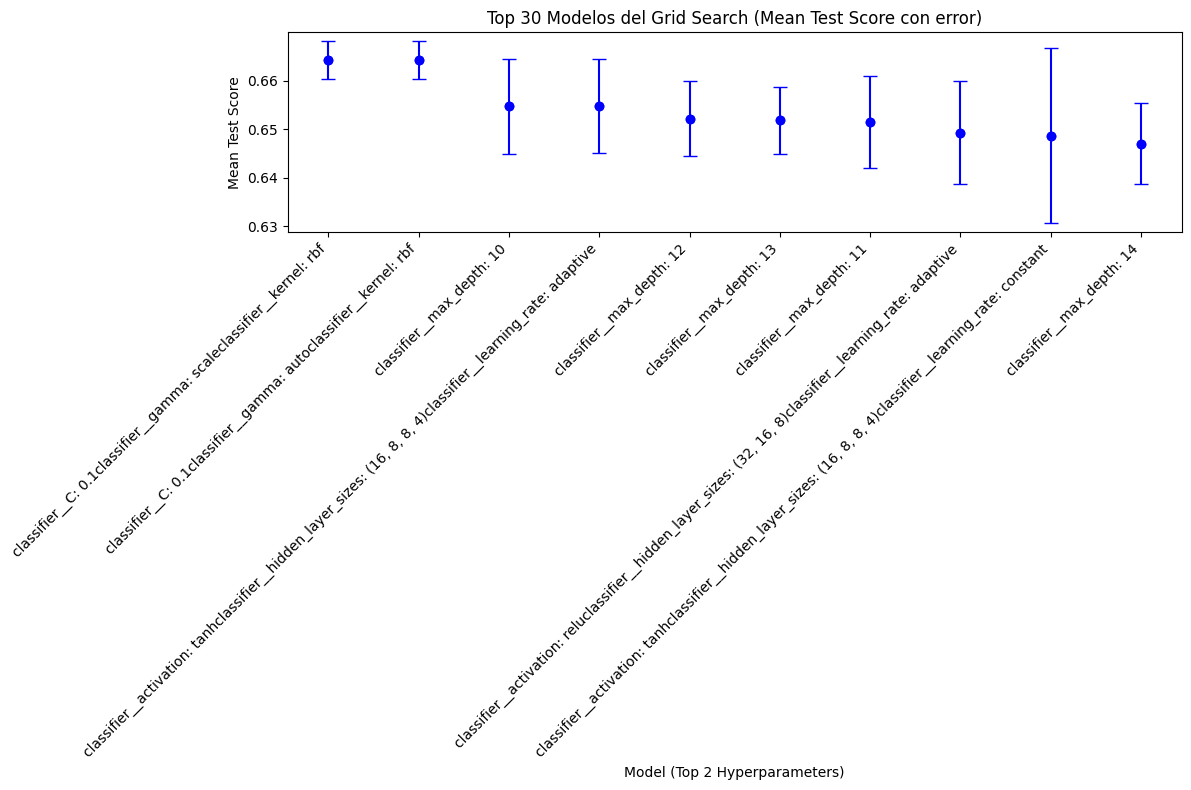

In [158]:
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)

# Seleccionar los 10 mejores modelos
top_n = 10
top_models = results_df.head(top_n)

# Extraer información relevante
mean_scores = top_models['mean_test_score']
std_scores = top_models['std_test_score']
params = top_models['params']

# Crear etiquetas detalladas con el nombre del modelo y los primeros dos parámetros
labels = [
    f"".join([f"{k}: {v}" for k, v in  list(param.items())[1:4]])
    for i, param in enumerate(params)
]

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 8))
plt.scatter(range(top_n), mean_scores, color='blue', label='Mean Test Score')
plt.errorbar(range(top_n), mean_scores, yerr=std_scores, fmt='o', color='blue', capsize=5)

# Añadir etiquetas en el eje X
plt.xticks(range(top_n), labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('Mean Test Score')
plt.xlabel('Model (Top 2 Hyperparameters)')
plt.title('Top 30 Modelos del Grid Search (Mean Test Score con error)')
plt.tight_layout()
plt.show()


El mejor modelo resulta ser SVC. Sin embargo, vemos que el modelo MLP tiene mucho margen de error, por lo que quizá se puede entrenar con más profundidad. Vamos a explorar esta opción en la sección Redes Neuronales, al final del trabajo.  

Mientras tanto, seguimos con SVC

In [159]:
results_df.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__max_depth,param_classifier__learning_rate,param_classifier__n_estimators,param_classifier__criterion,param_classifier__C,...,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
34,49.215009,1.761141,11.181586,0.454641,SVC(),NaN,NaN,NaN,NaN,0.1,...,NaN,"{'classifier': SVC(), 'classifier__C': 0.1, 'c...",0.660910,0.671019,0.663437,0.665543,0.660489,0.664280,0.003833,1
36,51.618526,0.908972,10.975972,0.399356,SVC(),NaN,NaN,NaN,NaN,0.1,...,NaN,"{'classifier': SVC(), 'classifier__C': 0.1, 'c...",0.660910,0.671019,0.663437,0.665543,0.660489,0.664280,0.003833,1
0,2.784007,0.081772,0.080690,0.007014,RandomForestClassifier(),10.0,NaN,NaN,NaN,NaN,...,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.649958,0.671019,0.654591,0.657119,0.641112,0.654760,0.009791,3
60,9.832162,1.405148,0.031362,0.004592,MLPClassifier(max_iter=500),NaN,adaptive,NaN,NaN,NaN,...,sgd,"{'classifier': MLPClassifier(max_iter=500), 'c...",0.655855,0.671019,0.651222,0.655013,0.640691,0.654760,0.009758,3
2,3.336620,0.096263,0.089464,0.003092,RandomForestClassifier(),12.0,NaN,NaN,NaN,NaN,...,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.650800,0.665122,0.653749,0.649958,0.641112,0.652148,0.007737,5
3,3.477744,0.109418,0.112244,0.005914,RandomForestClassifier(),13.0,NaN,NaN,NaN,NaN,...,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.652906,0.663858,0.644482,0.652485,0.645324,0.651811,0.006965,6
1,2.941575,0.060910,0.102287,0.008417,RandomForestClassifier(),11.0,NaN,NaN,NaN,NaN,...,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.652064,0.669334,0.648273,0.646588,0.641533,0.651559,0.009510,7
48,15.939269,1.652149,0.045682,0.005797,MLPClassifier(max_iter=500),NaN,adaptive,NaN,NaN,NaN,...,sgd,"{'classifier': MLPClassifier(max_iter=500), 'c...",0.658382,0.657540,0.652064,0.649115,0.629318,0.649284,0.010558,8
58,7.637192,0.795688,0.039721,0.001830,MLPClassifier(max_iter=500),NaN,constant,NaN,NaN,NaN,...,sgd,"{'classifier': MLPClassifier(max_iter=500), 'c...",0.675232,0.651222,0.622999,0.635636,0.658382,0.648694,0.018084,9
4,3.573809,0.028428,0.107279,0.004421,RandomForestClassifier(),14.0,NaN,NaN,NaN,NaN,...,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.637742,0.659225,0.647852,0.652485,0.637742,0.647009,0.008387,10


In [157]:
EVALUACION = False
best_clf = grid_search.best_estimator_ #Asignar aqui el mejor clasificador posible (previamente entrenado)
#best_clf = pl
#Leemos el dataset de evaluación, simulando producción
if EVALUACION==False:
    df = pd.read_csv(STUDENTDATAFILE)
    x_train_2, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv(EVALDATAFILE)
#Dividimos en target y predictoras

X_Eval = df.drop("Default", axis=1)
y_Eval = (df['Default'] == 'default').astype(int)  # Convertir a binario

#Evaluación final

y_pred = best_clf.predict(X_Eval) # esto debe ser un pipeline completo
print(classification_report(y_Eval, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      5069
           1       0.63      0.67      0.65      5133

    accuracy                           0.64     10202
   macro avg       0.64      0.64      0.64     10202
weighted avg       0.64      0.64      0.64     10202



La métrica de interés es **Recall** de la clase **default** (o 1, en este caso)

# Redes neuronales
Dado que todos los datos son numéricos, que la regresión logística tuvo buena performance y que el clasificador MLP tenía todavía bastante margen de error, exploramos la posibilidad de usar combinaciones distintas de redes neuronales con funciones de activación logística.
Dado que el dataset no es muy grande y los parametros de entrada y salida de la red neuronal tampoco, usamos fuerza bruta para calcular la mejor red posible

## Prueba de concepto (sin pipeline, hardcodeado y feo)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from joblib import Parallel, delayed
import pandas as pd

X_train_clean = X.drop(columns=['Objetivo', 'esPropietario']) # No numérico, luego evaluamos si lo necesitamos con onehot
Y_train_clean = y.drop(columns=['Objetivo', 'esPropietario']) # Idem

# Asegurarte de que se usa CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Simular datos de ejemplo (reemplazar con tus datos)
# Suponiendo que tienes X (features) y y (target)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_clean, Y_train_clean, test_size=0.3, random_state=42)

# Escalar los datos (como Proof of concept, luego esto sería un paso del pipeline)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)

# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train2.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test2.values, dtype=torch.float32).unsqueeze(1)

from torch.utils.data import DataLoader, TensorDataset
# Crear DataLoaders
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

# MLP con torch que recibe una lista de tamaños de capas ocultas
class DynamicMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(DynamicMLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size)) # Linear + Sigmoid = Logistic
            layers.append(nn.Sigmoid())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, 1)) # La salida es binaria. 1 neurona
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Loop para probar diferentes configuraciones de capas ocultas
hidden_layer_sizes = []
for i in range(16, 0, -1):
    for j in range(16, 0, -1):
        for k in range(16, 0, -1):
            for p in range(16, 0, -1):
                hidden_layer_sizes.append((i, j, k, p))

# Entrenar y evaluar el modelo. Lo hacemos en una función aislada para poder paralelizar el entrenamiento
def train_and_evaluate(hidden_sizes):
    for hidden_sizes in hidden_layer_sizes:
        print(f"Probando arquitectura: {hidden_sizes}")
        
        # Crear modelo
        model = DynamicMLP(input_size=X_train_tensor.shape[1], hidden_sizes=hidden_sizes).to(device)
        
        # Definir optimizador y función de pérdida
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01) # MLPClassifier de Scikit-learn ya demostró que Adam es mejor
        
        # Entrenamiento
        num_epochs = 20 # un número bajo para que no tome mucho tiempo, ya calculamos unas 2 horas para todas las posibilidades
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                # Mover datos a GPU
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Forward pass
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                # Backward pass y optimización
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
        
        # Evaluación
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = (outputs > 0.5).float()
                all_preds.append(preds.cpu())
                all_labels.append(y_batch.cpu())
            
        # Combinar resultados
        y_pred = torch.cat(all_preds).numpy()
        y_true = torch.cat(all_labels).numpy()
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        
        return {
            "hidden_sizes": hidden_sizes,
            "accuracy": report['accuracy'],
            "precision_default": report['1.0']['precision'],
            "recall_default": report['1.0']['recall'],
            "f1_default": report['1.0']['f1-score'],
            "model": model
        }
# Ejecutar en paralelo
results = Parallel(n_jobs=2)(
    delayed(train_and_evaluate)(hidden_sizes) for hidden_sizes in hidden_layer_sizes
)
# Mostrar los resultados
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


Usando dispositivo: cuda
  hidden_sizes  accuracy  precision_default  recall_default  f1_default  \
0     (16, 16)   0.63517           0.623275        0.694915    0.657148   

                                               model  
0  DynamicMLP(\n  (network): Sequential(\n    (0)...  


C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

Luego de 121 minutos de proceso en GPU, obtuvimos que la mejor red neuronal se obtiene con dos capas ocultas de tamaño 16 y 16. 
Notar que nuestra evaluación comprendió todas las posibilidades de 0 a 16 neuronas para 4 capas. Es posible que quizá se pueda mejorar permitiendo más neuronas en la misma cantidad o menos capas.

In [10]:
print(results_df['recall_default'].sort_values(ascending=False).head(10))

197    0.741672
80     0.740113
47     0.734074
216    0.730372
13     0.729788
129    0.728229
208    0.727839
193    0.726865
48     0.724722
50     0.724138
Name: recall_default, dtype: float64


In [26]:
# Seleccionar el mejor modelo segun el recall
best_model = results_df.loc[results_df['recall_default'].idxmax()]
print(best_model)

hidden_sizes                                                  (16, 16)
accuracy                                                       0.63517
precision_default                                             0.623275
recall_default                                                0.694915
f1_default                                                    0.657148
model                DynamicMLP(\n  (network): Sequential(\n    (0)...
Name: 0, dtype: object


Como el modelo fue entrenado con torch y no Scikit learn, tenemos que masajear un poco los datos antes de poder usarlos

In [40]:
#X_Eval.drop(columns=['Objetivo', 'esPropietario'], inplace=True)
# x_train_2.drop(columns=['Objetivo', 'esPropietario'], inplace=True)
#X_Eval.drop(columns=['Default'], inplace=True)
x_train_2.drop(columns=['Default'], inplace=True)
# Escalar los datos
scaler = StandardScaler()
x_train_2_scaled = scaler.fit(x_train_2)
X_test_scaled = scaler.transform(X_Eval)

# Convertir datos a tensores
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_Eval.values, dtype=torch.float32).unsqueeze(1)

# Crear DataLoaders
batch_size = 256
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

best_model.model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_model.model(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())

# Combinar resultados
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

In [42]:
print(report)

{'0.0': {'precision': 0.6503683858004019, 'recall': 0.5746695600710199, 'f1-score': 0.610180142438207, 'support': 5069.0}, '1.0': {'precision': 0.6232745063777739, 'recall': 0.6949152542372882, 'f1-score': 0.6571481208548269, 'support': 5133.0}, 'accuracy': 0.635169574593217, 'macro avg': {'precision': 0.636821446089088, 'recall': 0.634792407154154, 'f1-score': 0.6336641316465169, 'support': 10202.0}, 'weighted avg': {'precision': 0.6367364623465351, 'recall': 0.635169574593217, 'f1-score': 0.6338114532804447, 'support': 10202.0}}


El recall para la clase 1 (la de interés, que es si el cliente defaultea o no) es 0.69, el mejor resultado hasta el momento.  
El accuracy no empeoró por lo que no parece estar haciendo overfitting.  
Esto sirve como prueba de concepto, pero hay que adaptarlo para que pueda funcionar en el pipeline de Scikit learn y pase la validación cruzada de un GridSearchCV.

## Wrapper de modelo torch para scikit learn

In [85]:
import torch
from sklearn.base import BaseEstimator, ClassifierMixin

class TorchModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class=DynamicMLP, hidden_sizes=(12,12), device='cpu', num_epochs=20, lr=0.01, batch_size=32):
        self.model_class = model_class  # Clase del modelo, no podemos recibir un objeto porque GridSearchCV no lo soporta
        self.input_size = None # Se inicializa en fit
        self.hidden_sizes = hidden_sizes
        self.device = device
        self.num_epochs = num_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.model = None  # Se inicializa en fit

    def fit(self, X, y):
        self.input_size = X.shape[1]
        # Crear el modelo en cada ajuste
        self.model = self.model_class(self.input_size, self.hidden_sizes).to(self.device) # Instanciamos el modelo en fit
        self.classes_ = torch.unique(torch.tensor(y)).cpu().numpy()  # Definir clases únicas para que gridsearchcv distinga esta configuración del modelo del resto

        # Convertir X e y a tensores de PyTorch
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(self.device)
        
        # Configurar optimizador
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = torch.nn.BCELoss()

        # Crear DataLoader
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Entrenar el modelo
        self.model.train()
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            for X_batch, y_batch in dataloader:
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
        
        return self
    
    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            return (outputs > 0.5).float().cpu().numpy()
    
    def get_params(self, deep=True): 
        # Necesario para que GridSearchCV funcione, esto devuelve los atributos necesarios para instanciar la clase y conforma los parametros a probar por GridSearchCV
        return {
            'model_class': self.model_class,
            'hidden_sizes': self.hidden_sizes,
            'device': self.device,
            'num_epochs': self.num_epochs,
            'lr': self.lr,
            'batch_size': self.batch_size
        }

    def set_params(self, **params):
        # Idem get_params
        for key, value in params.items():
            setattr(self, key, value)
        return self



In [ ]:
# MLP que recibe su arquitectura por parametro
class DynamicMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(DynamicMLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.Sigmoid())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## Pipeline con el wrapper de torch

In [ ]:
df = pd.read_csv(STUDENTDATAFILE)
df['RelacionCuotaDeuda'] = df['RelacionCuotaDeuda'].round(0)
X = df.drop(columns='Default')
y = (df['Default'] == 'default').astype(int)  # Convertir a binario para MLP
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DynamicMLP(X_train.shape[1], [16, 16])

pl = Pipeline(steps=[
    ("one_hot", ColumnOneHot(columns=['Objetivo', 'esPropietario'])),
    ("outlier", ColumnOutlierRemover(column='IngresoAnuales', method='iqr', factor=1.5, replace_with_nan=True)),
    ("outlier2", ColumnOutlierRemover(column='PendienteEnTarjeta', method='iqr', factor=1.5, replace_with_nan=True)),
    ("outlier3", ColumnOutlierRemover(column='PuntuacionGeneral', method='iqr', factor=1.5, replace_with_nan=True)),
    ("outlier4", ColumnOutlierRemover(column='RelacionCuotaDeuda', method='iqr', factor=1.5, replace_with_nan=True)),
    ("imputer", ColumnImputer(columns=['IngresoAnuales', 'PendienteEnTarjeta', 'PuntuacionGeneral', 'RelacionCuotaDeuda'])),
    ('scaler', StandardScaler()), 
    ('classifier', TorchModelWrapper())
])

# Loop para probar diferentes configuraciones de capas ocultas. 
# En otros tests no vimos mejoras significativas en agregar más de dos capas. Las siguientes capas convergen a 1 neurona.
hidden_layer_sizes = []
for i in range(32, 0, -1):
    hidden_layer_sizes.append((i,))
    for j in range(32, 0, -1):
        hidden_layer_sizes.append((i, j)) # 32x32 capas x 5cv = 5120 fits. A 100 fits/minuto son ~51 minutos

# Convierte y_train a array NumPy
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

# Definir parámetros para cada clasificador
param_grid = [
    {
        'classifier': [TorchModelWrapper(model_class=DynamicMLP,device='cpu',num_epochs=20,lr=0.01,batch_size=256)],
        'classifier__hidden_sizes': hidden_layer_sizes
    }
]

# Realizar la búsqueda con GridSearchCV
grid_search = GridSearchCV(pl, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=3, error_score='raise')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Mejor modelo: {type(best_model.named_steps['classifier']).__name__}")
print("Mejores parámetros:", best_params)

# Evaluar en el conjunto de prueba
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1056 candidates, totalling 5280 fits
Mejor modelo: TorchModelWrapper
Mejores parámetros: {'classifier': TorchModelWrapper(batch_size=256), 'classifier__hidden_sizes': (5, 32)}
              precision    recall  f1-score   support

           0       0.66      0.54      0.59      5069
           1       0.61      0.72      0.66      5133

    accuracy                           0.63     10202
   macro avg       0.64      0.63      0.63     10202
weighted avg       0.64      0.63      0.63     10202



La arquitectura 5, 32 fue la que maximizó el recall en 0.72. Quizá si permitimos mayor cantidad de neuronas en la segunda capa se pueda mejorar este resultado, puesto que se maximizó dicha capa (sólo probamos hasta 32 neuronas por capa)

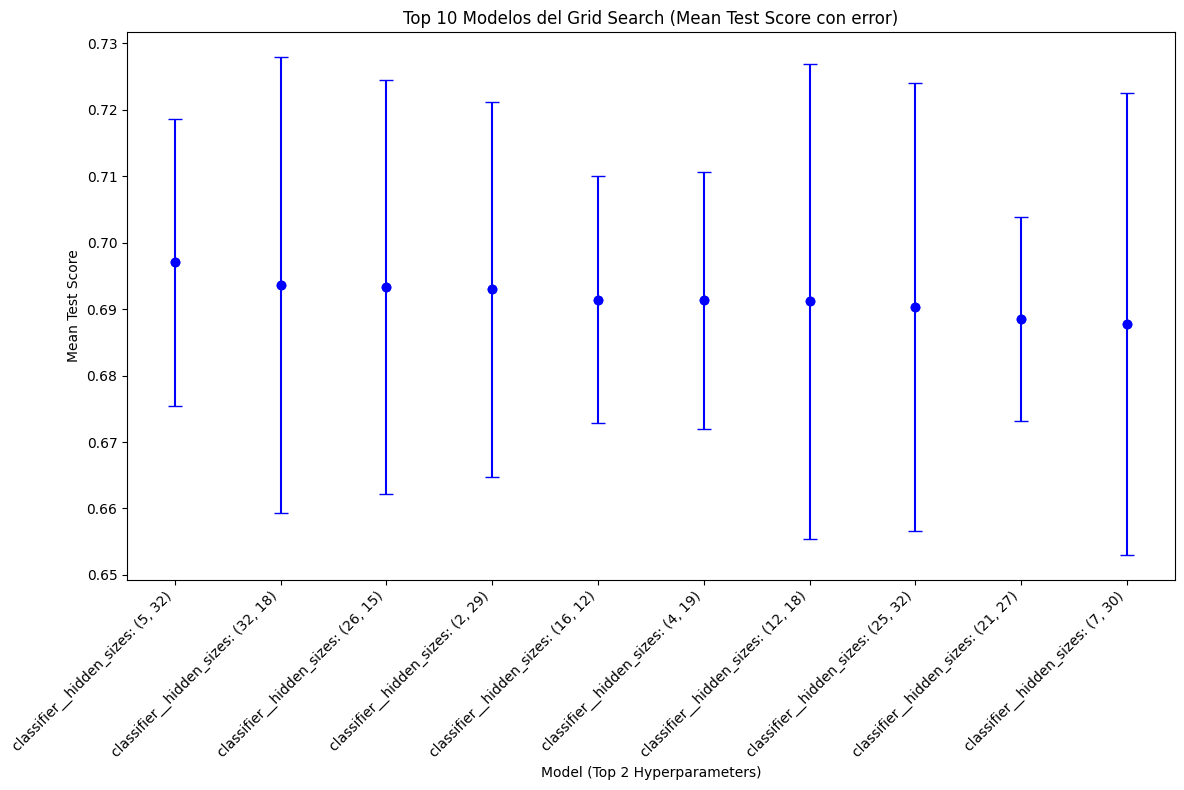

In [124]:
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)

# Seleccionar los 10 mejores modelos
top_n = 10
top_models = results_df.head(top_n)

# Extraer información relevante
mean_scores = top_models['mean_test_score']
std_scores = top_models['std_test_score']
params = top_models['params']

# Crear etiquetas detalladas con el nombre del modelo y los primeros dos parámetros
labels = [
    f"".join([f"{k}: {v}" for k, v in  list(param.items())[1:4]])
    for i, param in enumerate(params)
]

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 8))
plt.scatter(range(top_n), mean_scores, color='blue', label='Mean Test Score')
plt.errorbar(range(top_n), mean_scores, yerr=std_scores, fmt='o', color='blue', capsize=5)

# Añadir etiquetas en el eje X
plt.xticks(range(top_n), labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('Mean Test Score')
plt.xlabel('Model (Top 2 Hyperparameters)')
plt.title(f'Top {top_n} Modelos del Grid Search (Mean Test Score con error)')
plt.tight_layout()
plt.show()


In [125]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__hidden_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
892,6.339960,0.105856,0.027850,0.000801,TorchModelWrapper(batch_size=256),"(5, 32)",{'classifier': TorchModelWrapper(batch_size=25...,0.714406,0.718618,0.697978,0.696714,0.657540,0.697051,0.021580,1
15,7.001426,0.175217,0.032861,0.004959,TorchModelWrapper(batch_size=256),"(32, 18)",{'classifier': TorchModelWrapper(batch_size=25...,0.726201,0.679023,0.725358,0.634372,0.703033,0.693597,0.034295,2
216,6.590288,0.083016,0.026719,0.001239,TorchModelWrapper(batch_size=256),"(26, 15)",{'classifier': TorchModelWrapper(batch_size=25...,0.718197,0.739680,0.684920,0.664701,0.658804,0.693260,0.031142,3
994,6.403708,0.057247,0.030408,0.003183,TorchModelWrapper(batch_size=256),"(2, 29)",{'classifier': TorchModelWrapper(batch_size=25...,0.676074,0.698399,0.652064,0.736731,0.701769,0.693008,0.028216,4
549,6.363040,0.106944,0.029065,0.005558,TorchModelWrapper(batch_size=256),"(16, 12)",{'classifier': TorchModelWrapper(batch_size=25...,0.708088,0.689975,0.713985,0.662174,0.682814,0.691407,0.018539,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,6.414216,0.063674,0.028153,0.001724,TorchModelWrapper(batch_size=256),"(9, 25)",{'classifier': TorchModelWrapper(batch_size=25...,0.596462,0.570345,0.656276,0.593934,0.629318,0.609267,0.030086,1052
1036,6.177883,0.135452,0.027001,0.001188,TorchModelWrapper(batch_size=256),"(1, 20)",{'classifier': TorchModelWrapper(batch_size=25...,0.608256,0.557709,0.676917,0.625105,0.577928,0.609183,0.041155,1053
865,6.298387,0.126529,0.030041,0.001301,TorchModelWrapper(batch_size=256),"(6, 26)",{'classifier': TorchModelWrapper(batch_size=25...,0.612468,0.614996,0.591828,0.634372,0.588458,0.608425,0.016774,1054
732,6.487445,0.039939,0.028360,0.002231,TorchModelWrapper(batch_size=256),"(10, 27)",{'classifier': TorchModelWrapper(batch_size=25...,0.613311,0.660489,0.618787,0.487784,0.654170,0.606908,0.062413,1055


In [126]:
EVALUACION = False
best_clf = grid_search.best_estimator_ #Asignar aqui el mejor clasificador posible (previamente entrenado)
#best_clf = pl
#Leemos el dataset de evaluación, simulando producción
if EVALUACION==False:
    df = pd.read_csv(STUDENTDATAFILE)
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv(EVALDATAFILE)
#Dividimos en target y predictoras

X_Eval = df.drop("Default", axis=1)
y_Eval = (df['Default'] == 'default').astype(int)  # Convertir a binario

#Evaluación final

y_pred = best_clf.predict(X_Eval) # esto debe ser un pipeline completo
print(classification_report(y_Eval, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60      5069
           1       0.62      0.72      0.66      5133

    accuracy                           0.63     10202
   macro avg       0.64      0.63      0.63     10202
weighted avg       0.64      0.63      0.63     10202



Vemos que el MLP con capas (5, 32) todas utilizando función de activación Logistica logra un recall considerablemente superior que SVC, sin perder accuracy.